![Just Truth](https://memegenerator.net/img/instances/81017670/what-if-i-told-you-pytorch-tensorflow.jpg)

## Дубро пужаловат


#### Это маленький гайдик по PyTorch, в котором вы можете найти все тоже самое что мы делали и в keras, но ...!


### Если вы поймете что PyTorch лучше keras'a, то со временем PyTorch перестанет греть ваш стул, а начнет греть вам душу.

Официальный сайт <a href = "https://pytorch.org/">PyTorch</a> Там же можно его и скачать. Обратите внимание, что скорее всего вы смертны и у вас нет <b>cuda</b>.

<a href = "https://pytorch.org/features">Почему же PyTorch хорош?</a>

<a href = "https://pytorch.org/tutorials/">Туториалы 18+</a>

<a href = "https://pytorch.org/docs/stable/index.html">Документация (English Alert)</a>

In [1]:
#Импрортируем чаво-то, потом может что-то добавим 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange, tqdm_notebook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#Импортируем данные и немного делаем разные гадости

data = pd.read_csv("telecom_churn.csv")
print(data.shape)

from sklearn.preprocessing import OneHotEncoder, StandardScaler

ohe_state = pd.get_dummies(data.State)
yn = {"Yes":1, "No":0}

data = pd.concat([ohe_state, data], axis = 1)
target = data["Churn"]
data = data.drop(["State", "Churn"], axis = 1)

data["Voice mail plan"] = [yn[i] for i in data["Voice mail plan"]]
data["International plan"] = [yn[i] for i in data["International plan"]]

(3333, 20)


In [4]:
ss = StandardScaler()
ss.fit(data)

X = ss.transform(data)
Y = np.array([int(i) for i in target])

In [5]:
#Импортируем торч - факел
# torch - это в основном мат. функции
# torch.nn - это в основном слои и другие придлуды вроде Loss для NN
# torch.nn.functional - тоже самое что и nn, только там функции не привязаны к обьектам и еще кое-что

import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
#Заранее посмотрим распределение 1 к 0 в выборке
#Маловато, так что потом сдеаем кое-что

print("Amount of Positives: {}".format(len(np.where(Y == 1)[0])/len(Y)))

Amount of Positives: 0.14491449144914492


### Let's write simple sequential model

In [177]:
#Что-то знакомое? Да почти как в Keras.
#Но это moviton и потом, вы - джедаи, перейдете на темную сторону классов

model = nn.Sequential()
model.add_module("Linear_1", nn.Linear(X.shape[1], 40))
model.add_module("Linear_2", nn.Linear(40, 20))                 
model.add_module("ReLU_1", nn.ReLU())
model.add_module("Linear_3", nn.Linear(20, 1))
model.add_module("Sigmoid_1", nn.Sigmoid())                

In [178]:
#Маленький классик для вывода тренда значения ошибки в realtime.
#Класс самопальный, не кидайте гнилыми помидорами

from IPython.display import clear_output
import matplotlib.pyplot as plt

class LossTrend():
    def __init__(self):
        self.losses = []
         
    def plot_trend(self, epochs = None):
        plt.grid()
        plt.axvline(0, c = 'black')
        plt.axhline(0, c = 'black')
        plt.axhline(min(self.losses), c = 'green')
        plt.plot(list(range(len(self.losses))), self.losses, c = 'red', lw = 1)
        plt.scatter([len(self.losses)-1], [self.losses[-1]], c = 'red')
        clear_output(True)
        out = "Loss: {}".format(self.losses[-1])
        if epochs != None:
            out += " Epochs: {}".format(epochs)
        print(out)
        plt.show()
        
    def add_loss(self,new_loss_score, plot_period = 0, epochs = None):
        self.losses.append(new_loss_score)
        if plot_period:
            if len(self.losses) % plot_period == 0:
                self.plot_trend(epochs)

In [179]:
#Бьем на train и test

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [180]:
#Одна из фичей торча в том что он numpy-like. Его струтуру tensor можно легко менять в np.ndarray и обратно

X_train = torch.tensor(X_train).type(torch.FloatTensor)
X_test = torch.tensor(X_test).type(torch.FloatTensor)
Y_train = torch.tensor(Y_train).type(torch.FloatTensor)
Y_test = torch.tensor(Y_test).type(torch.FloatTensor)

In [181]:
#Вспоминаем что, при рандомом батче у нас будет слишком много False и потом берем и делаем вероятность
#взятия каждого элемента из X_train, которая обратно пропорциональна количеству вхождений этого ответа в X_train 

pos_len = len(np.where(Y_train == 1)[0])
neg_len = len(np.where(Y_train == 0)[0])
pn = {True:pos_len, False:neg_len}
policy = [1/2/pn[i.item()] for i in Y_train]

In [182]:
loss_trend = LossTrend()

Loss: 0.1582038700580597 Epochs: 999


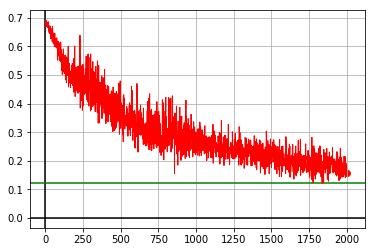

100%|██████████| 1000/1000 [00:37<00:00, 26.35it/s]


In [184]:
#Выбираем оптимайзер

opt = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Кол-во эпох и размер батча, с этим можете поиграться

epochs = 1000

batch_size = 256

for epoch in trange(epochs):
    #Выбираем рандомные индексы для батча, с респектом на policy
    
    its = np.random.choice(range(X_train.size()[0]), batch_size, p = policy)
    
    #Делаем предсказание
    
    pred = model(X_train[its])
    
    y = Y_train[its]
    
    #Считаем ошибку
    
    loss = nn.functional.binary_cross_entropy(pred, y)
    
    #Пробрасываем градиенты
    
    loss.backward()
    
    #Шагаем оптимайзером
    
    opt.step()
    
    #Зануляем градиенты, чтобы следующий шаг был "чистым"
    
    opt.zero_grad()
    
    #Добавляем ошибку в графико-строитель
    
    loss_trend.add_loss(loss.item(), plot_period=10, epochs=epoch)

In [202]:
#Считаем ROC-AUC и получаем вминяемый результат.

from sklearn.metrics import roc_auc_score, accuracy_score

print("ROC-AUC-Score train: {}".format(roc_auc_score(Y_train, model(X_train).detach().numpy())))
print("ROC-AUC-Score test: {}".format(roc_auc_score(Y_test, model(X_test).detach().numpy())))

ROC-AUC-Score train: 0.9818315983957461
ROC-AUC-Score test: 0.8399647821363008


### Итоги

Всего за 10 минут на PyTorch'e можно написать все тоже самое что было написано на Keras'e. Но как уже было сказано, если отбросить мирские хотелки вроде автоматического обучения, то можно осознать что PyTorch это тот самый низкоуровневый инструмент, который настолько низкоуровневый насколько надо, чуть ниже уже абстракции, но при том очень быстрый и к тому же, дающий возможность построить сверху более высокие концепции. Вуот...

###### ДЗ? Я если честно ХЗ? Хочу знать вообщем.

Попробуйте написать классификацию для MNIST проблемы через обычные Linear (CNN мы пока что еще не прошли). Если что то можно стучаться ко мне в телеграмм <b>@Punctuality</b>